# Initial analysis

A first look at the received data from CBS


### Initialization
Initialization of the libraries and csv or excel data files

In [1]:
import urllib.request as urllib, os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

filename = 'Coosto_berichten.csv'
datafolder = 'data/'

try:
    os.mkdir(datafolder)
except FileExistsError:
    pass

data = pd.read_csv('data/' + filename, delimiter=';')

### Cleaning
After the initialization a cleaning and possibly enriching process will be performed to make the data usable. 

In [2]:
def count_missing(x):
  return sum(x.isnull())
print("Missing values per column:")
print(data.apply(count_missing, axis=0))

Missing values per column:
Unnamed: 0             0
Unnamed: 0.1           0
Unnamed: 0.1.1         0
datum                  0
url                    0
sentiment              0
discussielengte        0
views                  0
auteur                 0
GPS breedtegraad    3837
GPS lengtegraad     3837
bericht tekst         17
likes count            0
datum utc              0
hashtags               0
dtype: int64


### Pie chart

<<explanation>>

Neutral:  5242
Positive:  3045
Negative:  150


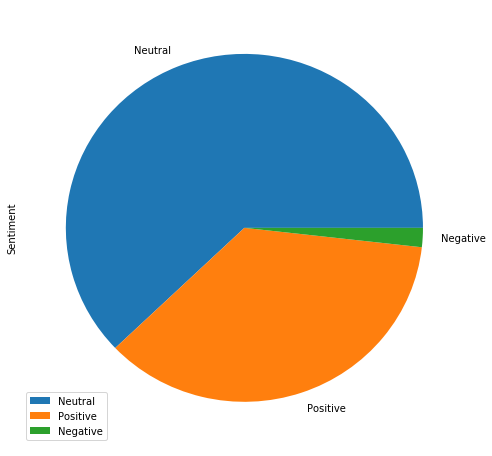

In [6]:
# Sentiment neutral
print('Neutral: ', len(data.loc[data['sentiment']=='0']))

# Sentiment positive
print('Positive: ', len(data.loc[data['sentiment'] == '+']))

# Sentiment negative
print('Negative: ', len(data.loc[data['sentiment'] == '-']))

# Pie chart
pd.DataFrame({'Sentiment': [len(data.loc[data['sentiment'] == '0']), 
                          len(data.loc[data['sentiment'] == '+']),
                          len(data.loc[data['sentiment'] == '-'])]}, index=['Neutral', 'Positive', 'Negative']).plot.pie(y='Sentiment', figsize=(8,8))



### Comments vs post

In [7]:
# Pie chart
#pd.DataFrame({'Type': [len(data.loc[data['type'] == 'post']),
                          #len(data.loc[data['type'] == 'comment'])]}, index=['Post', 'Comment']).plot.pie(y='Type', figsize=(8,8))


### Bar chart

<<explanation>>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000234CE62BBE0>,
      dtype=object)

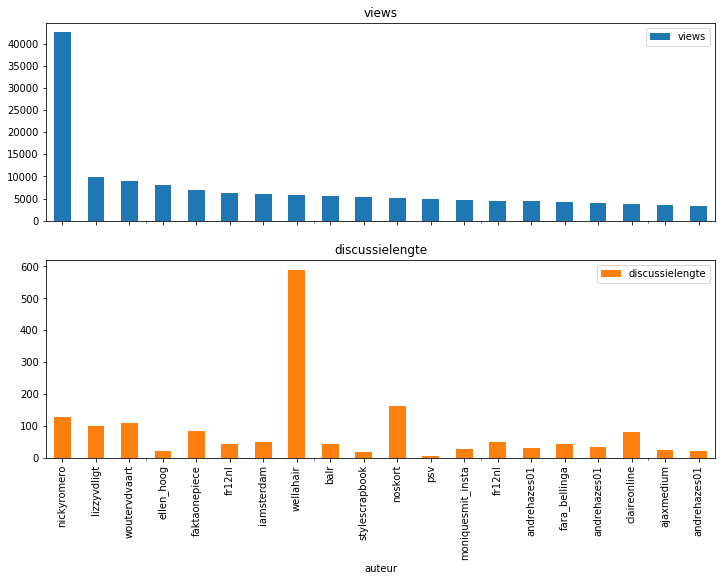

In [8]:
data.sort_values(by='views', ascending=False).head(10)

data.sort_values(by='views', ascending=False).head(20)\
    .plot.bar(x='auteur', y=['views', 'discussielengte'], rot=90, subplots=True, figsize=(12,8))

### Scatter chart

<>

Within The Netherlands: 4422 of 8437


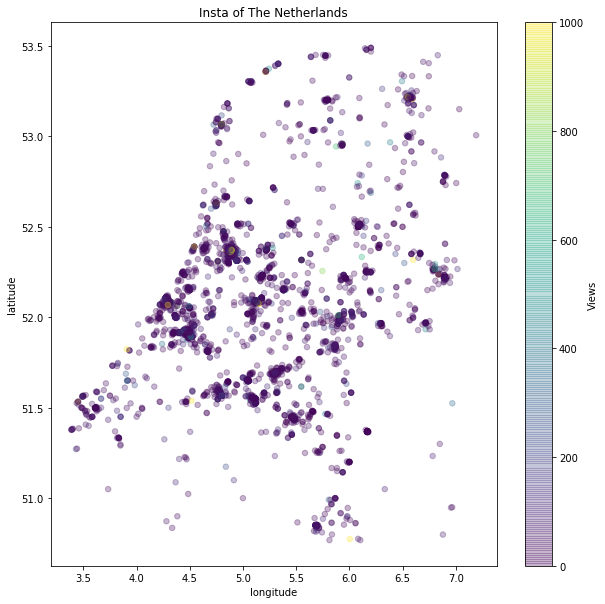

In [18]:
data_gps = data
data_gps = data_gps.loc[3.2 <= data_gps['GPS lengtegraad']]
data_gps = data_gps.loc[7.4 >= data_gps['GPS lengtegraad']]
data_gps = data_gps.loc[50.7 <= data_gps['GPS breedtegraad']]
data_gps = data_gps.loc[53.6 >= data_gps['GPS breedtegraad']]

plt.figure(figsize=[10,10]);

plt.title('Insta of The Netherlands')
plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.xlim(3.2,7.4)
#plt.ylim(50.7,53.6)
sizes = 120

print('Within The Netherlands:', len(data_gps), 'of', len(data))

points=plt.scatter(data_gps['GPS lengtegraad'], data_gps['GPS breedtegraad'], marker='.'
                   , c=data_gps.views
                   , s=sizes**1
                   , alpha=0.3
                   , cmap='viridis')

plt.clim(0,1000)

plt.colorbar(label='Views');

In [11]:
# Under construction because of the cleaning

# plt.figure(figsize=[10,10]);

# plt.title('Views vs discussion')
# plt.xlabel('views')
# plt.ylabel('discussionlength')
# #plt.xlim(3.2,7.4)
# #plt.ylim(50.7,53.6)
# sizes = 120

# points=plt.scatter(data['views'], data_gps['discussielengte'], marker='.'
#                    , s=sizes**1
#                    , alpha=0.3
#                    , cmap='binary')

# plt.clim(0,1000)

## Area chart

<<explanation>>

## Line chart

<<explanation>>

Text(0,0.5,'Number of posts')

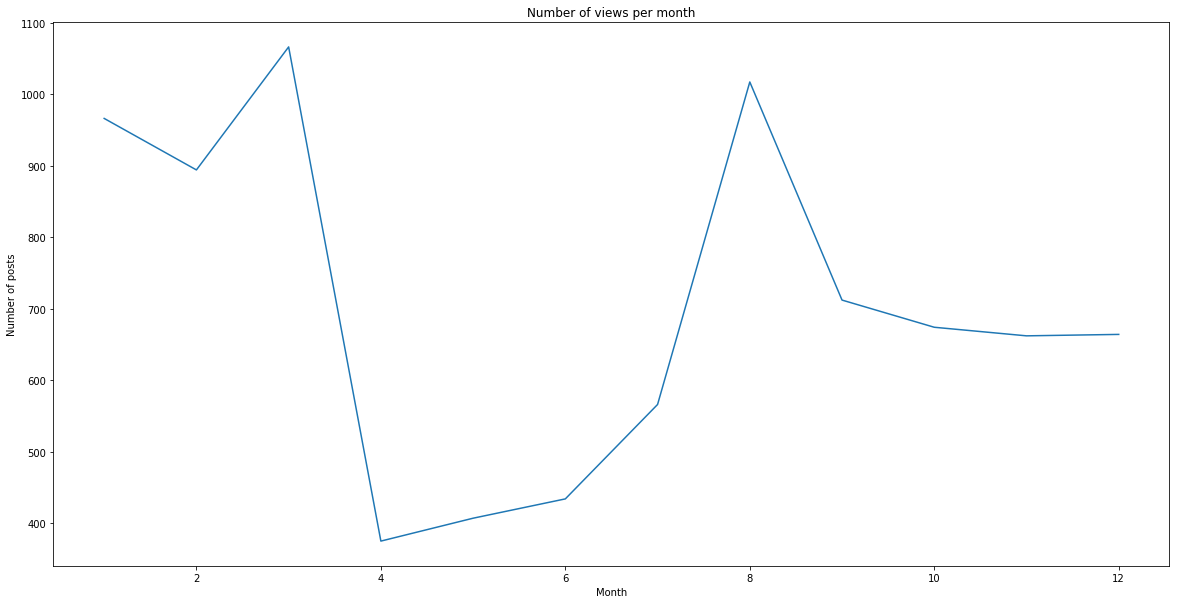

In [20]:
# Step 1: Convert to datetime
data['datum'] = pd.to_datetime(data['datum'], errors='coerce')
# Step 2: Make extra column with month number
data['Month'] = data['datum'].dt.month

data['Month'].value_counts().sort_index().plot(title='Number of views per month', \
                                               figsize=(20,10))
plt.xlabel('Month')
plt.ylabel('Number of posts')

## Scatter matrix

<<explanation>>

## Histogram

<<explanation>>

We're gonna start with seeing how many times someone posts more than once. So this means that for example there could be three people who have posted 8 times. This would be represented as 8 -- 3

In [21]:
data.head(10)
x = data['auteur'].value_counts()
x.value_counts().sort_index()

# Plotting is not useful yet, more data needed
# plt.hist(x)
# plt.show()

1    7165
2     400
3      86
4      21
5      15
6       4
7       2
8       1
9       1
Name: auteur, dtype: int64

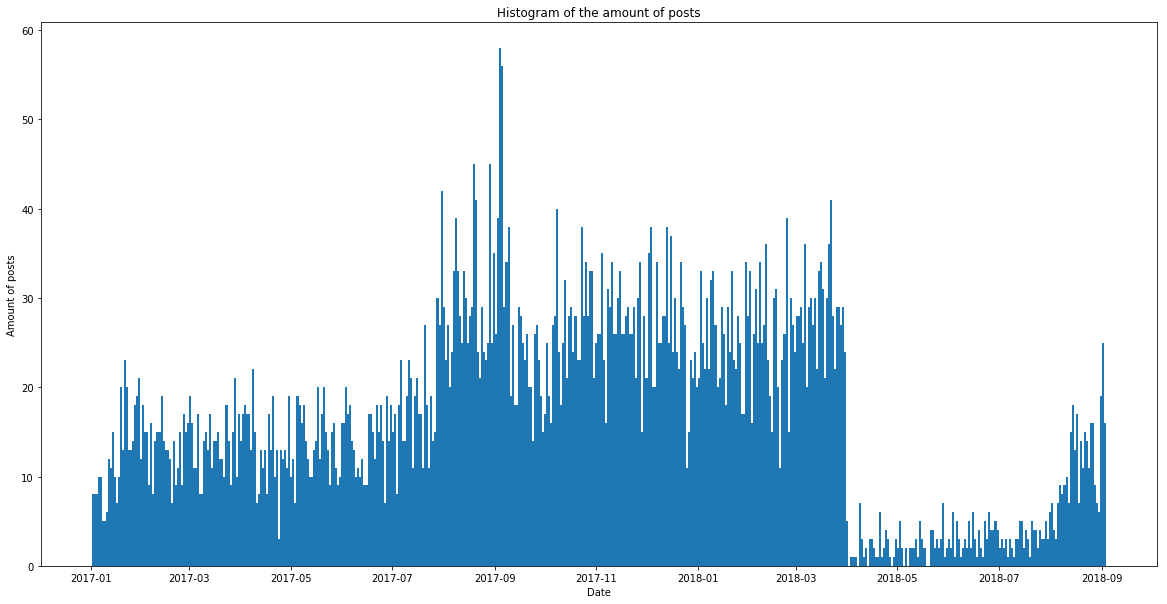

In [22]:
data['datum'] = data['datum'].astype("datetime64")

fig = plt.figure(figsize=(20,10))

bins = 500
plt.hist(data['datum'], bins=bins)

plt.xlabel('Date')
plt.ylabel('Amount of posts')
plt.title('Histogram of the amount of posts')
plt.show()

## Hoeveelheid hashtags

(0, 40)

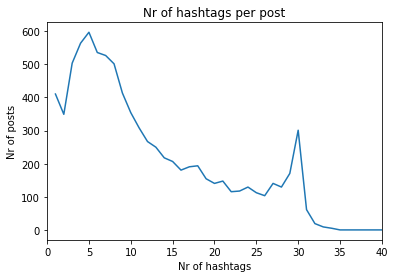

In [4]:
noh = []
for i in range(len(data.hashtags)):
    str1 = data['hashtags'][i].replace(']','').replace('[','').replace(' ','').replace('\'', '')
    str2 = str1.replace('"','').split(",")
    nr = len(str2)
    noh.append(nr)
noh = pd.Series(noh)
plt.plot(noh.value_counts().sort_index())
plt.title('Nr of hashtags per post')
plt.ylabel('Nr of posts')
plt.xlabel('Nr of hashtags')
plt.xlim(0, 40)

# Creating our wordmap
Here we first setup our dictionary of dutch and english stopwords

In [3]:
with open('data/stopwords-nl.txt', 'r') as f:
    dict_nl = f.read().splitlines()
    dict_nl.extend(['aan']) # Add missing dutch words here

with open('data/stopwords-eng.txt', 'r') as f:
    dict_eng = f.read().splitlines()
    #dict_eng.extend(['']) # Add missing english words here
    
# Combine two dictionaries for easy use

dict_all = dict_nl
dict_all.extend(dict_eng)

Next up, we set up our Instagram image for later

In [5]:
from PIL import Image
mask = np.array(Image.open('data/Instagram_logo.png'))

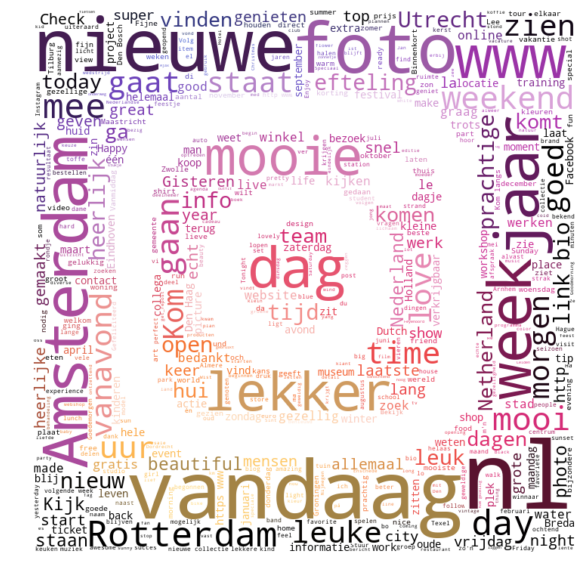

In [6]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

cloud = WordCloud(background_color="white", max_words=500, stopwords=dict_all, mask=mask)

image_colors = ImageColorGenerator(mask)
positive_cloud = cloud.generate(data['bericht tekst'].str.cat(sep='\n'))
plt.figure(figsize=(10,10))
plt.imshow(positive_cloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

# Hashtag wordmap

In [3]:
# convert the hashtags from string to numpy array
for i, row in data.iterrows():
    data.set_value(i, 'hashtags', 
                   np.array(data['hashtags'][i].replace(']','').replace('[','').replace(' ','').replace('\'', '').replace('"','').split(",")))

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


In [4]:
# get all the hashtags and put them in a numpy array
# RUN ONLY ONCE (takes very long)

data_hashtags = np.array([])
for i, row in data.iterrows():
     data_hashtags = np.append(data_hashtags, data['hashtags'][i])

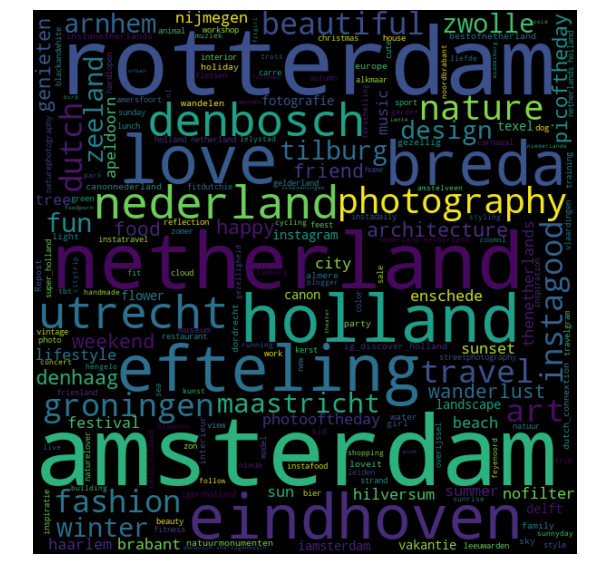

In [5]:
# run: pip install wordcloud
from wordcloud import WordCloud

cloud = WordCloud(width=600, height=600, background_color="black", max_words=200)

positive_cloud = cloud.generate(" ".join(hashtag for hashtag in data_hashtags))
plt.figure(figsize=(10,10))
plt.imshow(positive_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()